In [1]:
%matplotlib inline
import utils; reload(utils)
from utils import *

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [2]:
# path = '..data/redux/sample/'
path = '../data/redux/'
model_path = path + 'models/'

In [3]:
# batch_size = 4
batch_size = 64

In [4]:
model = vgg_ft(2)

In [5]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  0           zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [6]:
# import previously fine tuned model's weights
model.load_weights(path+'results/ft1.h5')

In [7]:
layers = model.layers

In [8]:
conv_layers_idxs = [i for i,layer in enumerate(layers) if type(layer) == Convolution2D]

In [9]:
last_conv_layer_idx = conv_layers_idxs[-1]
last_conv_layer_idx

30

In [10]:
conv_layers = layers[:last_conv_layer_idx+1]
conv_model = Sequential(conv_layers)

In [11]:
fc_layers = layers[last_conv_layer_idx+1:]

In [12]:
batches = get_batches(path+'train/',batch_size=batch_size)
val_batches = get_batches(path+'valid/',batch_size=batch_size)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [13]:
trn_classes = batches.classes
valid_classes = val_batches.classes

In [14]:
trn_labels = onehot(trn_classes)
valid_labels = onehot(valid_classes)

In [15]:
val_batches.nb_sample

2000

In [16]:
# trn_features = conv_model.predict_generator(batches,batches.nb_sample)
# val_features = conv_model.predict_generator(val_batches,val_batches.nb_sample)

In [17]:
# save_array(model_path+'conv_trn_features.bc',trn_features)
# save_array(model_path+'conv_val_features.bc',val_features)

In [18]:
trn_features = load_array(model_path+'conv_trn_features.bc')
val_features = load_array(model_path+'conv_val_features.bc')

In [19]:
trn_features.shape

(23000, 512, 14, 14)

In [20]:
def proc_wgts(layer) :return [o/2 for o in layer.get_weights()]

In [21]:
from keras.optimizers import SGD, RMSprop, Adam
opt = RMSprop(lr=0.00001, rho=0.7)

In [22]:
def fc_model():
    model = Sequential([
            MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
            Flatten(),
            Dense(4096,activation='relu'),
            Dropout(0.),
            Dense(4096,activation='relu'),
            Dropout(0.),
            Dense(2,activation='softmax')
        ])
    for l1,l2 in zip(model.layers,fc_layers):
        l1.set_weights(proc_wgts(l2))
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [23]:
fc_model = fc_model()

In [24]:
fc_model.fit(trn_features,trn_labels,
            nb_epoch=8,batch_size=batch_size,
            validation_data=(val_features,valid_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/8
23000/23000 [==============================] - 33s - loss: 0.7069 - acc: 0.4937 - val_loss: 0.6938 - val_acc: 0.5230
Epoch 2/8
23000/23000 [==============================] - 33s - loss: 0.6235 - acc: 0.6658 - val_loss: 0.7294 - val_acc: 0.5200
Epoch 3/8
23000/23000 [==============================] - 33s - loss: 0.4048 - acc: 0.8295 - val_loss: 0.9618 - val_acc: 0.5130
Epoch 4/8
23000/23000 [==============================] - 33s - loss: 0.1540 - acc: 0.9429 - val_loss: 1.4948 - val_acc: 0.4935
Epoch 5/8
23000/23000 [==============================] - 34s - loss: 0.0373 - acc: 0.9888 - val_loss: 1.9482 - val_acc: 0.5055
Epoch 6/8
23000/23000 [==============================] - 34s - loss: 0.0106 - acc: 0.9978 - val_loss: 2.4471 - val_acc: 0.5120
Epoch 7/8
23000/23000 [==============================] - 34s - loss: 0.0117 - acc: 0.9976 - val_loss: 2.8268 - val_acc: 0.5120
Epoch 8/8
23000/23000 [==============================] - 34s -

In [ ]:
fc_model.summary()

#### Approaches to Reduce Overfitting

1. Add more data
2. Data Augmentation
3. Reduce architecture complexity or use architectures that generalise well.
4. Add Regularisation or Dropouts

#### Data Augmentation

In [86]:
from keras.preprocessing import image
import numpy as np
gen = image.ImageDataGenerator(rotation_range=10,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               horizontal_flip=True,
                               zoom_range=0.1
                              )

In [87]:
from scipy import ndimage
# img_loc = 'data/dogscats/test/7.jpg'
img = np.expand_dims(ndimage.imread('../img/softmax.png'),0)

In [88]:
img.shape

(1, 363, 485, 3)

In [89]:
aug_iter = gen.flow(img)

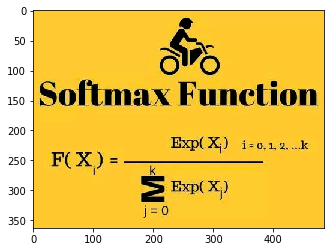

In [90]:
import matplotlib.pyplot as plt
plt.imshow(img[0])
plt.show()

In [91]:
aug_imgs = [next(aug_iter)[0].astype(np.uint8) for i in range(8)]

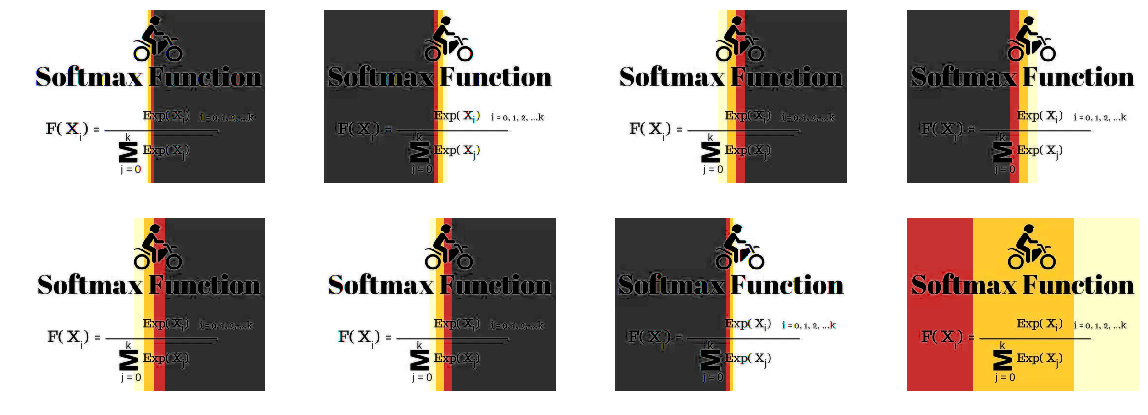

In [92]:
from utils import *
plots(aug_imgs,(20,7),2)
plt.show()

In [93]:
# ??np.expand_dims
K.set_image_dim_ordering('th')